In [1]:
import ast

from collections import Counter

import contractions

from gensim.models import Word2Vec

from itertools import chain

import joblib

import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import matplotlib.pyplot as plt

import mlflow
import mlflow.sklearn

import multiprocessing

from nltk import ngrams
from nltk.probability import FreqDist

import numpy as np

import pandas as pd

import re

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


import spacy
import en_core_web_sm

from exploration_utils import *

#  1. Preprocesamiento básico y exploración

### Definición de semillas para garantizar la reproducibilidad

In [2]:
seed=0
np.random.seed(seed)

## Descarga del corpus

In [3]:
reviews_df=pd.read_json('./Cell_Phones_and_Accessories_5.json', lines =  True)

In [4]:
reviews_df.iloc[0]


reviewerID                                           A30TL5EWN6DFXT
asin                                                     120401325X
reviewerName                                              christina
helpful                                                      [0, 0]
reviewText        They look good and stick good! I just don't li...
overall                                                           4
summary                                                  Looks Good
unixReviewTime                                           1400630400
reviewTime                                              05 21, 2014
Name: 0, dtype: object

In [5]:
reviews_df=reviews_df.drop(['reviewerID','asin','reviewerName','helpful','summary','unixReviewTime','reviewTime'], axis=1)

## Preprocesamiento preliminar

Comprobams si debemos hacer tratamiento de datos nulos o si no los hay:

In [6]:
reviews_df.isnull().sum()

reviewText    0
overall       0
dtype: int64

Hacemos un preprocesamiento básico inicial para poder explorar los datos:

* Converir a minusculas
* Deshacer contracciones
* Eliminar puntuación
* Mantener solo valores alfabéticos
* Convertir a ASCII
* Eliminar stopwords excepto 'no' y 'not', y lemmatizar

Este preprocesamiento permite unificaar distintas formas de la misma palabra para facilitar la exploración y hacer que en esta tengamos datos más representativos

In [7]:
print("CUDA available:", spacy.prefer_gpu())

CUDA available: True


In [ ]:
english_nlp = spacy.load("en_core_web_sm")

reviews_df['processed_tokens'] = reviews_df['reviewText'].apply(lambda x: basic_preprocessing(text=x,language_model=english_nlp))

reviews_df.to_csv("cleaned_reviews.csv", index=False)

Reimportación del dataframe (esta vez con las reviews preprocesadas en lemmas)

In [8]:
reviews_df=pd.read_csv('./cleaned_reviews.csv', sep=',')

# Convert lists imported as strings to lists
reviews_df['processed_tokens'] = reviews_df['processed_tokens'].apply(ast.literal_eval)

Creación de una columna en el dataframe con los tokens unidos usando espacios como separador. Esto será util para posteriores pasos de exploración.

In [9]:
reviews_df['processed_reviews'] = reviews_df['processed_tokens'].apply(lambda tokens: " ".join(tokens))

In [10]:
reviews_df.head(10)

,reviewText,overall,processed_tokens,processed_reviews
0,They look good and stick good! I just don't li...,4,"[look, good, stick, good, not, like, rounded, ...",look good stick good not like rounded shape bu...
1,These stickers work like the review says they ...,5,"[sticker, work, like, review, say, stick, grea...",sticker work like review say stick great stay ...
2,These are awesome and make my phone look so st...,5,"[awesome, phone, look, stylish, far, year, bel...",awesome phone look stylish far year believe ye...
3,Item arrived in great time and was in perfect ...,4,"[item, arrive, great, time, perfect, condition...",item arrive great time perfect condition order...
4,"awesome! stays on, and looks great. can be use...",5,"[awesome, stay, look, great, multiple, apple, ...",awesome stay look great multiple apple product...
5,These make using the home button easy. My daug...,3,"[home, button, easy, daughter, like, purchase,...",home button easy daughter like purchase worth ...
6,Came just as described.. It doesn't come unstu...,5,"[come, describe, not, come, unstuck, cute, peo...",come describe not come unstuck cute people ask...
7,it worked for the first week then it only char...,1,"[work, week, charge, phone, waste, money]",work week charge phone waste money
8,"Good case, solid build. Protects phone all aro...",5,"[good, case, solid, build, protect, phone, goo...",good case solid build protect phone good acces...
9,This is a fantastic case. Very stylish and pro...,5,"[fantastic, case, stylish, protect, phone, eas...",fantastic case stylish protect phone easy acce...


## Tamaño del dataset

In [11]:
print(f"Disponemos de {len(reviews_df)} reviews y calificaciones de productos.")

Disponemos de 194439 reviews y calificaciones de productos.


## Cardinalidad del vocabulario lemmatizado y sin stopwords

In [12]:

all_words = list(chain.from_iterable(reviews_df['processed_tokens']))

In [13]:
word_frequency = Counter(all_words)

print(f'La cardinalidad del vocabulario es {len(word_frequency)}')

La cardinalidad del vocabulario es 65789


## Distribución de reviews por calificación

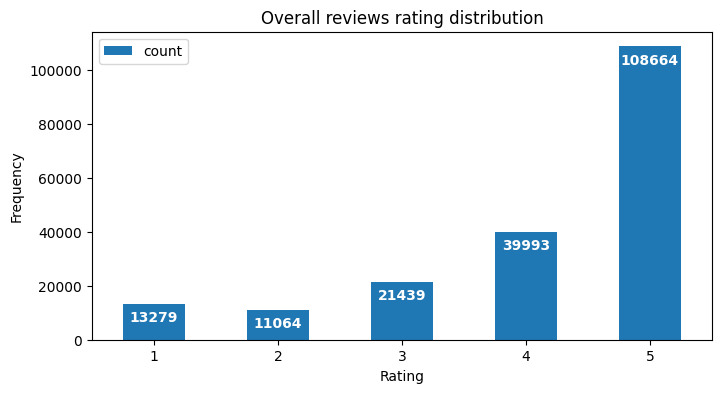

In [14]:
reviews_frequency = pd.DataFrame(reviews_df['overall'].value_counts(sort=False).sort_index())

axes = reviews_frequency.plot(kind='bar', title='Overall reviews rating distribution', figsize=(8, 4))

for p in axes.patches:
    axes.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                xytext=(0, -10), 
                textcoords="offset points", 
                ha='center', 
                va='center', 
                fontsize=10, 
                color='white',
                fontweight='bold') 

plt.xticks(rotation=0) 
axes.set_ylabel("Frequency")
axes.set_xlabel("Rating")

plt.show()


Vemos que el dataset está muy desbalanceado.

## Número de reviews positivas y negativas

Clasificaremos las calificaciones en 2 categorías: 0 (sentieminto negativo) y 1 (sentiento positivo).

* Sentimiento positivo (le asignaremos valor 1): ⭐⭐⭐⭐ / ⭐⭐⭐⭐⭐
* Sentimiento positivo (le asignaremos valor 0): ⭐ / ⭐⭐ / ⭐⭐⭐


In [15]:
def label_sentiment(row):
    if int(row) > 3:
        return 1
    else:
        return 0
    
reviews_df['sentiment_label'] = reviews_df.apply(lambda row: label_sentiment(row['overall']), axis=1)

In [16]:
reviews_df.head(10)

,reviewText,overall,processed_tokens,processed_reviews,sentiment_label
0,They look good and stick good! I just don't li...,4,"[look, good, stick, good, not, like, rounded, ...",look good stick good not like rounded shape bu...,1
1,These stickers work like the review says they ...,5,"[sticker, work, like, review, say, stick, grea...",sticker work like review say stick great stay ...,1
2,These are awesome and make my phone look so st...,5,"[awesome, phone, look, stylish, far, year, bel...",awesome phone look stylish far year believe ye...,1
3,Item arrived in great time and was in perfect ...,4,"[item, arrive, great, time, perfect, condition...",item arrive great time perfect condition order...,1
4,"awesome! stays on, and looks great. can be use...",5,"[awesome, stay, look, great, multiple, apple, ...",awesome stay look great multiple apple product...,1
5,These make using the home button easy. My daug...,3,"[home, button, easy, daughter, like, purchase,...",home button easy daughter like purchase worth ...,0
6,Came just as described.. It doesn't come unstu...,5,"[come, describe, not, come, unstuck, cute, peo...",come describe not come unstuck cute people ask...,1
7,it worked for the first week then it only char...,1,"[work, week, charge, phone, waste, money]",work week charge phone waste money,0
8,"Good case, solid build. Protects phone all aro...",5,"[good, case, solid, build, protect, phone, goo...",good case solid build protect phone good acces...,1
9,This is a fantastic case. Very stylish and pro...,5,"[fantastic, case, stylish, protect, phone, eas...",fantastic case stylish protect phone easy acce...,1


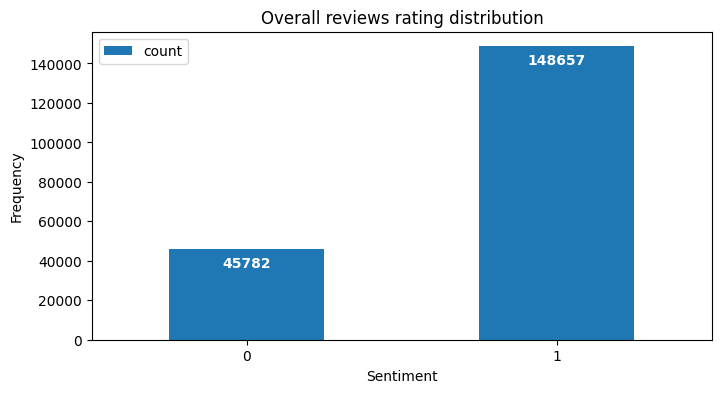

In [17]:
sentiment_frequency = pd.DataFrame(reviews_df['sentiment_label'].value_counts(sort=False).sort_index())

axes = sentiment_frequency.plot(kind='bar', title='Overall reviews rating distribution', figsize=(8, 4))

for p in axes.patches:
    axes.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                xytext=(0, -10), 
                textcoords="offset points", 
                ha='center', 
                va='center', 
                fontsize=10, 
                color='white',
                fontweight='bold')

plt.xticks(rotation=0) 
axes.set_ylabel("Frequency")
axes.set_xlabel("Sentiment")

plt.show()

De nuevo, al igual que en la distribución por reviwes vemos que tenemos un dataset muy desbalanceado. Deberemos tenerlo en cuenta, especialmente de cara a en qué métricas del modelo debemos fijarnos más.

El resto de la exploración la haremos únicamente sobre los datos de train para no introducir sesgos derivados de la exploración de datos de test

##  División en test y train

Dejamos un 20% de los ejemplo para test y utilizamos un 80% para train

Estratificamos para asegurar que mantenemos la proporcion de clases en las eqiquetas de sentimiento.

In [18]:
train_df, test_df = train_test_split(
    reviews_df, 
    test_size = 0.2, 
    shuffle = True, 
    random_state = seed, 
    stratify=reviews_df['sentiment_label'].values
)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [19]:
train_df.head()

,reviewText,overall,processed_tokens,processed_reviews,sentiment_label
0,Micro USB is the new standard in cellular devi...,5,"[micro, usb, new, standard, cellular, device, ...",micro usb new standard cellular device bold mi...,1
1,"I only use tech armor on my devices, I keep my...",5,"[use, tech, armor, device, phone, key, pocket,...",use tech armor device phone key pocket not sin...,1
2,First the pieces that hold the case together c...,2,"[piece, hold, case, crack, color, layer, start...",piece hold case crack color layer start peel f...,0
3,The iPhone 5c Wallet Case works well but may n...,4,"[iphone, c, wallet, case, work, not, fit, s, n...",iphone c wallet case work not fit s need look ...,1
4,Excellent ! Super fit looks really good on not...,4,"[excellent, super, fit, look, good, note, thin...",excellent super fit look good note thing make ...,1


## N-grams más frecuentes

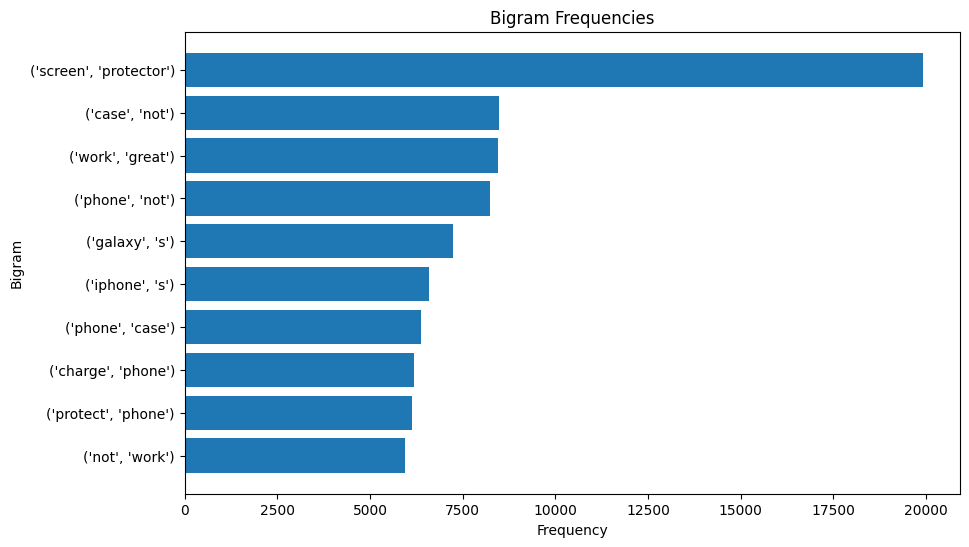

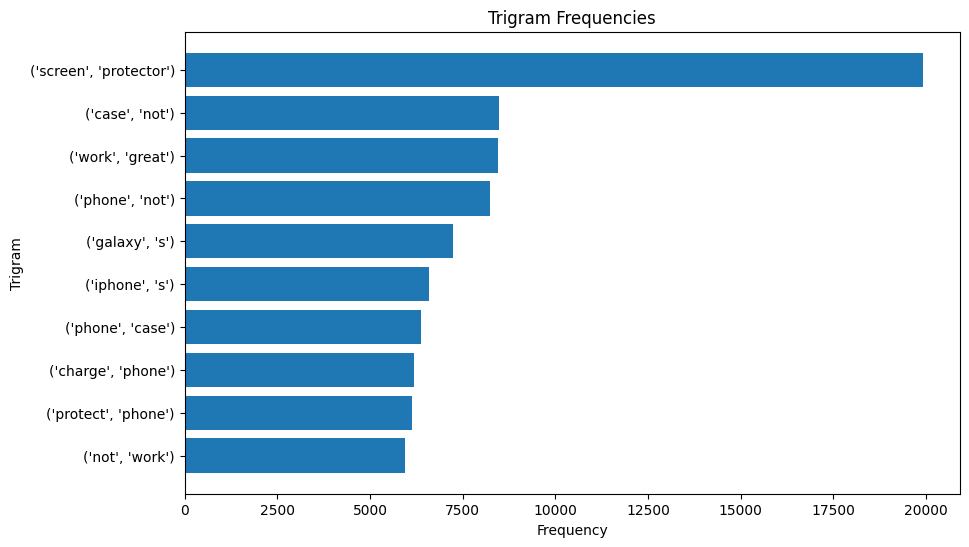

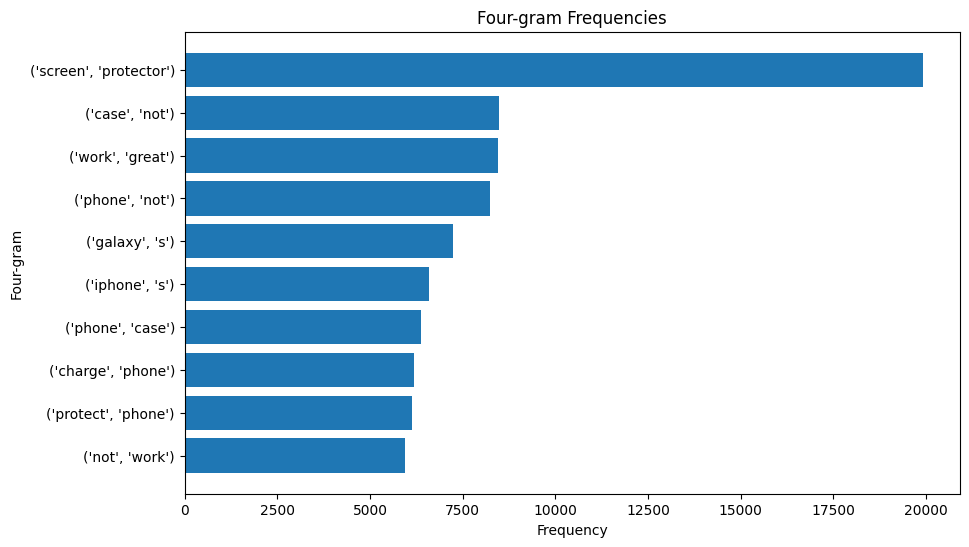

In [20]:
bigrams = []
trigrams = []
fourgrams = []

for tokens in train_df['processed_tokens']:
    bigrams.extend(list(ngrams(tokens, 2)))
    trigrams.extend(list(ngrams(tokens, 2)))
    fourgrams.extend(list(ngrams(tokens, 2)))

bigrams_freq = FreqDist(bigrams)
trigrams_freq = FreqDist(trigrams)
fourgrams_freq = FreqDist(fourgrams)

bigrams_freq_most_common = bigrams_freq.most_common(10)
trigrams_freq_most_common = trigrams_freq.most_common(10)
fourgrams_freq_most_common = fourgrams_freq.most_common(10)

plot_ngram_frequencies(bigrams_freq_most_common, 'Bigram')
plot_ngram_frequencies(trigrams_freq_most_common, 'Trigram')
plot_ngram_frequencies(fourgrams_freq_most_common, 'Four-gram')



Vemos que entre las palabras más frecuentes en los n-gramas la denominación del objeto descrito ("phone", "galaxy", "iphone"...). Posteriormente, haremos un segundo procesamienya eliminando algunas de  palabras ya que no aportan información al sentimiento de la review. Sin embargo, sí mantendremos algunos de los productos frecuentes como, 'case' o 'protector', ya que estos sí podrían formar parte de la review de otro producto que ha sido descrito como frágil, por ejemplo.

También vemos 's' como una palabra frecuente en los n-gramas. Eliminaremos palabras de longitud inferior a 2, ya que no nos aportan información.

 Procesaremos los datos eliminando palabras comunes que simplemente sean

## WordClouds

Negative sentiment WordCloud:


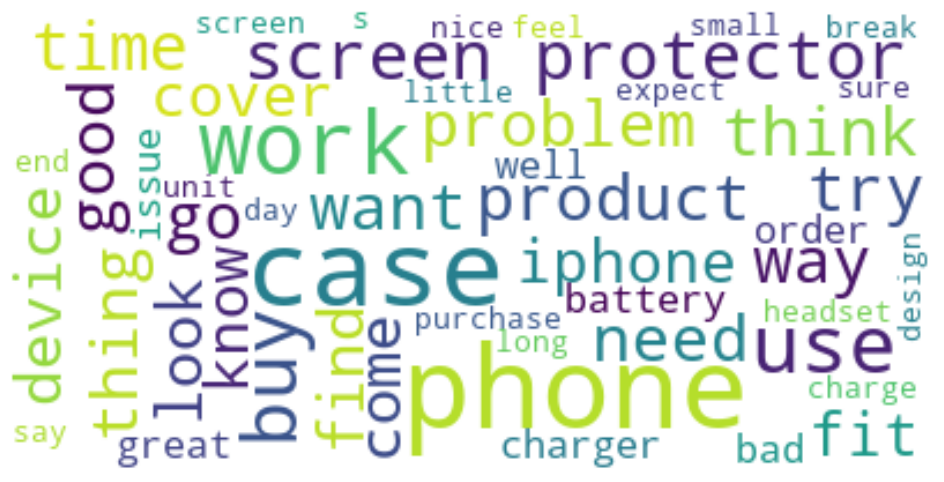

Positive sentiment WordCloud:


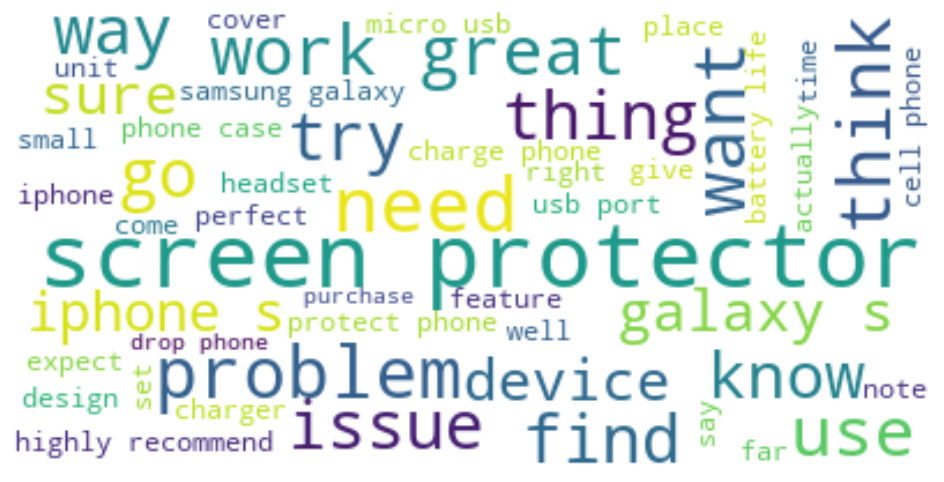

In [21]:
combined_text_negative = " ".join(train_df.loc[train_df['sentiment_label']==0, 'processed_reviews'])
combined_text_positive = " ".join(train_df.loc[train_df['sentiment_label']==1, 'processed_reviews'])

print('Negative sentiment WordCloud:')
plot_word_cloud(combined_text_negative)
print('Positive sentiment WordCloud:')
plot_word_cloud(combined_text_positive)

Vemos que hay palabras que se encuentran en ambos WordClouds. Tiene sentido ya que en su mayoría se refiren al producto descrito.

Además, al igual que en el paso anterior detectamos palabras que son muy comunes pero que solo se refieren al producto en sí o sus componentes y que no aportan información al sentimiento: screen, product, device...

## Visualización 2D de word embeddings

### Definición y entrenamiento del un modelo Word2Vec para obtener palabras similares

Definción del modelo Word2Vec

In [22]:
cores= multiprocessing.cpu_count() 

w2v_model = Word2Vec(
		min_count=5,
		window=2,
		vector_size=100,
		sample=6e-5,
		alpha=0.03,
		min_alpha=0.0007,
		negative=20,
		workers=cores-1
)

INFO - 18:14:48: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.03>', 'datetime': '2025-02-23T18:14:48.022771', 'gensim': '4.3.3', 'python': '3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'created'}


Construcción del vocabulario

In [23]:

reviews = [row.split() for row in train_df['processed_reviews']]
w2v_model.build_vocab(
		reviews, 
		progress_per=20000
)

print(f'Vocabulario compuesto por {len(w2v_model.wv.key_to_index)} palabras')

INFO - 18:14:48: collecting all words and their counts
INFO - 18:14:48: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 18:14:48: PROGRESS: at sentence #20000, processed 813345 words, keeping 19210 word types
INFO - 18:14:48: PROGRESS: at sentence #40000, processed 1623831 words, keeping 27552 word types
INFO - 18:14:48: PROGRESS: at sentence #60000, processed 2441574 words, keeping 34098 word types
INFO - 18:14:48: PROGRESS: at sentence #80000, processed 3260338 words, keeping 40282 word types
INFO - 18:14:48: PROGRESS: at sentence #100000, processed 4062235 words, keeping 45382 word types
INFO - 18:14:48: PROGRESS: at sentence #120000, processed 4865504 words, keeping 50204 word types
INFO - 18:14:48: PROGRESS: at sentence #140000, processed 5665290 words, keeping 54548 word types
INFO - 18:14:48: collected 57830 word types from a corpus of 6297389 raw words and 155551 sentences
INFO - 18:14:48: Creating a fresh vocabulary
INFO - 18:14:48: Word2Vec lifecycle 

Vocabulario compuesto por 14438 palabras


Entrenamineto del modelo 

In [24]:
w2v_model.train(
    train_df['processed_tokens'], 
    total_examples = w2v_model.corpus_count,
    epochs = 30,
    report_delay = 1 
)

INFO - 18:14:49: Word2Vec lifecycle event {'msg': 'training model with 31 workers on 14438 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2 shrink_windows=True', 'datetime': '2025-02-23T18:14:49.062366', 'gensim': '4.3.3', 'python': '3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'train'}
INFO - 18:14:50: EPOCH 0 - PROGRESS: at 63.77% examples, 1624246 words/s, in_qsize 61, out_qsize 0
INFO - 18:14:50: EPOCH 0: training on 6298369 raw words (2541578 effective words) took 1.5s, 1731588 effective words/s
INFO - 18:14:51: EPOCH 1 - PROGRESS: at 68.13% examples, 1732931 words/s, in_qsize 60, out_qsize 1
INFO - 18:14:51: EPOCH 1: training on 6298369 raw words (2542195 effective words) took 1.4s, 1778491 effective words/s
INFO - 18:14:53: EPOCH 2 - PROGRESS: at 70.32% examples, 1792278 words/s, in_qsize 61, out_qsize 0
INFO - 18:14:53: EPOCH 2: training on 629836

(76279014, 188951070)

### Creación de clusters

Definición de clusters de con palabras similares:

In [25]:
key_words = ['protector','buy','good', 'problem', 'small']
embedding_clusters = []
word_clusters = []

for word in key_words:
    
    embeddings = []
    words = []
    
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        #Extract word numeric value
        embeddings.append(w2v_model.wv[similar_word])
    
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

### Definición y entrenamiento de un modelo TSNE con reducción de la dimensionalidad para visualización 2D

Definición del modelo TSNE

In [26]:
n_components = 2

tsne_model_2d = TSNE(
		perplexity = 20, 
		n_components = n_components, 
		init = 'pca',
		max_iter = 3500,
		random_state = seed
)

Reducción de la dimenisonalidad de los embeddings

In [27]:

embedding_clusters = np.array(embedding_clusters)
initial_words_number, similar_words_number, vector_dimension = embedding_clusters.shape

embeddings_2d = np.array(
		# Reduce la segunda componente de la matriz 2D (vector_dimension) a n_components definido en el modelo
		tsne_model_2d.fit_transform(
				# transforma la matriz 3D en 2D con las dimensiones indicadas
				embedding_clusters.reshape(
						initial_words_number * similar_words_number, 
						vector_dimension 
				)
		)
# Restaurar la estructura 3D volviendo a dividir la primera dimensión en 2
).reshape(
		initial_words_number, 
		similar_words_number, 
		n_components
)

c:\Users\Lucia\.conda\envs\despliegue_NLP\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Lucia\.conda\envs\despliegue_NLP\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Lucia\.conda\envs\despliegue_NLP\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lucia\.conda\envs\despliegue_NLP\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Lucia\.conda\envs\desplie

### Representación de clusters

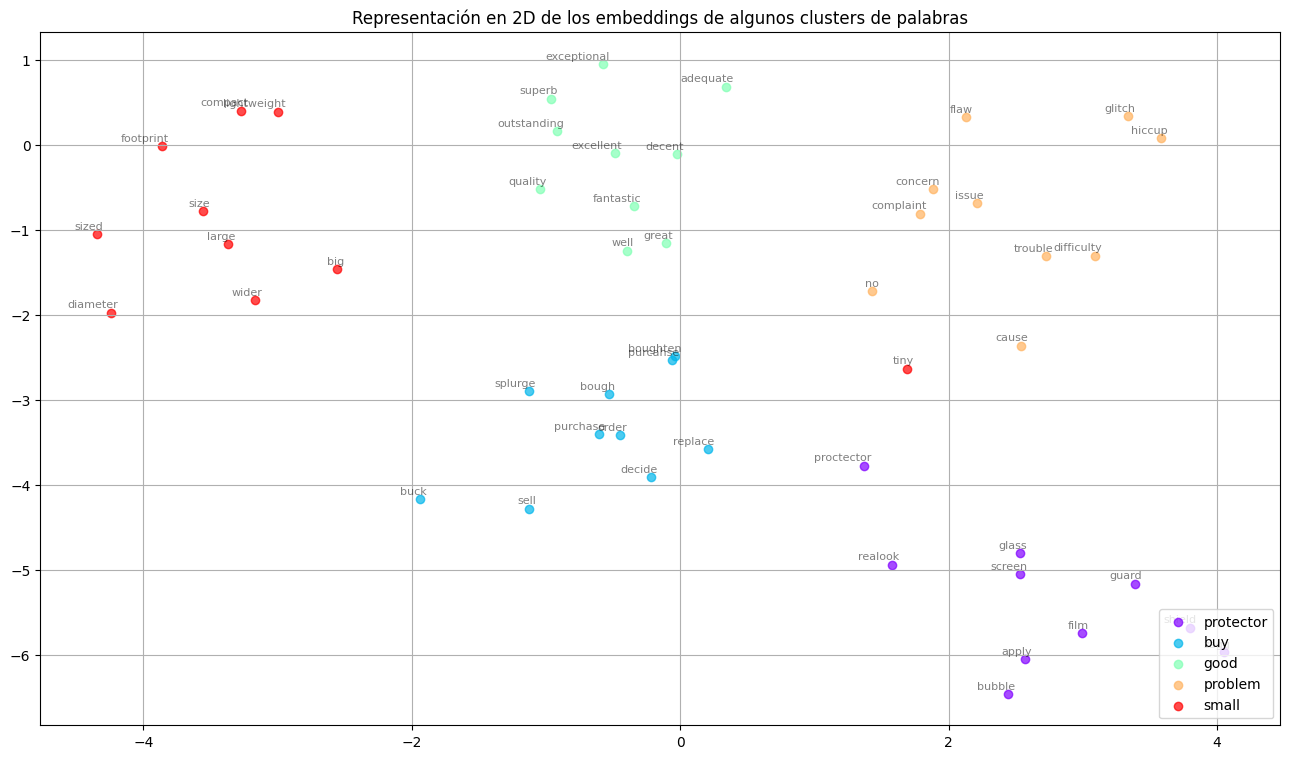

In [28]:
tsne_plot_similar_words(key_words, embeddings_2d, word_clusters)

Vemos que los clusters de las palabras seleccionadas no se mezclan entre sí.

Además, vemos coherencia en las smilitudes encontradas:
* Protector -> palabras relacionadas con protectores de pantalla
* Buy -> palabras relacionadas con compras (tanto por parte de vender como comprar). 'Stumbling' llama la atención, quizá se da a frases del tipo 'stumbling upon a good deal'
* Good -> palabras calificativas que indican satisfacicción con los productos. Vemos ejemplos tanto de calificación suficiento como de calificación sobresaliente.
* Problem -> palabras relacionadas con defectos o resolución de problemas ('fine' tendría solo sentido si hablase de multas o penalizaciones)
* Small -> palabras sobre dimensiones (no necesariamente pequeñas, ya que entre ellas están 'large' o 'big')


De nuevo, tetectamos un par de marcas de productos (de protectores de pantalla) que eliminaremos en el siguiente procesamiento de datos adicional.

# 2. Procesamiento de datos a partir de lo detectado en la exploración

Eliminamos stopwords adicionales como algunas marcas, productos, o componentes de estos.

Definimos nuevos dataframes con los datos procesados diviendo X e y.

In [29]:
stop_words = ['skinomi', 'zagg', 'screen', 'product', 'device', 'cell', 'phone', 
              'iphone', 'galaxy', 'charger', 'headset', 'battery', 'usb', 'samsung']

train_df, val_df = train_test_split(
    train_df, 
    test_size = 0.2, 
    shuffle = True, 
    random_state = seed, 
    stratify=train_df['sentiment_label'].values
)

X_train_df = pd.DataFrame()
X_val_df = pd.DataFrame()
X_test_df = pd.DataFrame()
y_train_df = pd.DataFrame()
y_val_df = pd.DataFrame()
y_test_df = pd.DataFrame()

X_train_df['reviews'] = (
    train_df['processed_tokens']
        .apply(lambda x: additional_preprocessing(tokens=x,stopwords=stop_words, token_min_length=2))
)

X_val_df['reviews'] = (
    val_df['processed_tokens']
        .apply(lambda x: additional_preprocessing(tokens=x,stopwords=stop_words, token_min_length=2))
)

X_test_df['reviews'] = (
    test_df['processed_tokens']
        .apply(lambda x: additional_preprocessing(tokens=x,stopwords=stop_words, token_min_length=2))
)

y_train_df['sentiment_label']=train_df['sentiment_label']
y_val_df['sentiment_label']=val_df['sentiment_label']
y_test_df['sentiment_label']=test_df['sentiment_label']


# 3. Entrenamiento y evaluación monitorizada de modelos de análisis de sentimiento

Hacemos un pipeline de entrenamiento de un modelo Random Forest con diferentes parámetros tanto del vectorizador usado (TF-IDF).

Se consideran difrentes valores de los siguientes parámetros:

* número máximo de features
* número de elementos de los n-gramas
* número de árboles del Random Forest

Nuestro modelo pretende un equilibrio entre una adecuada entre la calidad de la clasificación pasitiva y negativa:

* Los casos positivos nos permiten presentarle al cliente resultados más atractivos de los que sea más susceptible de comprarlos. Además estos pueden ser tomados como ejemplo para el desarrollo de nuevos productos.
* Los casos negativos nos permiten analizar las oportunidades de mejora en la satisfacción del cliente.

Teniendo en cuenta lo anterior y que tenemos un datased desbalancead, elegiremos métricas weighted avg y por clase, f1-score y recall, más concretamente.

In [90]:
ngram_range_list = [(1,2),(2,3)]
max_features_list=[3500,1500]
n_estimators_list = [50,100]

mlflow.set_experiment('Sentiment Analysis of Cell Phone and Accessories Reviews')

experiment_no=1
for ngram_range in ngram_range_list:
    for max_features in max_features_list:
        for n_estimators in n_estimators_list:
            
            tf_idf_vectorizer = TfidfVectorizer(ngram_range = ngram_range, max_df=0.95, max_features=max_features)

            rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)

            tfidf_rf_pipeline = Pipeline([
                ('feature_nlp', tf_idf_vectorizer),
                ('model', rf_model)
            ])

            tfidf_rf_pipeline.fit(X_train_df['reviews'], y_train_df['sentiment_label'])
            
            y_train_pred = tfidf_rf_pipeline.predict(X_train_df['reviews'])
            y_val_pred = tfidf_rf_pipeline.predict(X_val_df['reviews'])
            y_test_pred = tfidf_rf_pipeline.predict(X_test_df['reviews'])

            classif_report_train = classification_report(y_train_df['sentiment_label'], y_train_pred, output_dict=True)
            classif_report_val = classification_report(y_val_df['sentiment_label'], y_val_pred, output_dict=True)
            classif_report_test = classification_report(y_test_df['sentiment_label'], y_test_pred, output_dict=True)

            
            with mlflow.start_run(run_name='Experiment_'+str(experiment_no)):
                
                mlflow.log_metric('weighted_avg_f1_score_train', classif_report_train['weighted avg']['f1-score'])
                mlflow.log_metric('weighted_avg_f1_score_val', classif_report_val['weighted avg']['f1-score'])
                mlflow.log_metric('weighted_avg_f1_score_test', classif_report_test['weighted avg']['f1-score'])

                mlflow.log_metric('0_class_f1_score_train', classif_report_train['0']['f1-score'])
                mlflow.log_metric('0_class_f1_score_val', classif_report_val['0']['f1-score'])
                mlflow.log_metric('0_class_f1_score_test', classif_report_test['0']['f1-score'])

                mlflow.log_metric('1_class_f1_score_train', classif_report_train['1']['f1-score'])
                mlflow.log_metric('1_class_f1_score_val', classif_report_val['1']['f1-score'])
                mlflow.log_metric('1_class_f1_score_test', classif_report_test['1']['f1-score'])

                mlflow.log_metric('wighted_avg_recall_train', classif_report_train['weighted avg']['recall'])
                mlflow.log_metric('wighted_avg_recall_val', classif_report_val['weighted avg']['recall'])
                mlflow.log_metric('wighted_avg_recall_test', classif_report_test['weighted avg']['recall'])

                mlflow.log_metric('0_class_recall_train', classif_report_train['0']['recall'])
                mlflow.log_metric('0_class_recall_val', classif_report_val['0']['recall'])
                mlflow.log_metric('0_class_recall_test', classif_report_test['0']['recall'])

                mlflow.log_metric('1_class_recall_train', classif_report_train['1']['recall'])
                mlflow.log_metric('1_class_recall_val', classif_report_val['1']['recall'])
                mlflow.log_metric('1_class_recall_test', classif_report_test['1']['recall'])

                mlflow.log_param('tfidf_ngram_range', ngram_range)
                mlflow.log_param('tfidf_max_df', 0.95)
                mlflow.log_param('tfidf_max_features', max_features)
                mlflow.log_param('rf_n_estimators', n_estimators)
                mlflow.log_param('rf_random_state', seed)

                mlflow.sklearn.log_model(tfidf_rf_pipeline, 'tfidf_rf_pipeline')
            
            experiment_no += 1

2025/02/23 12:29:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/23 12:34:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/23 12:37:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/23 12:43:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/23 12:46:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/23 12:53:19 

Entramos en mlflow para ver los experientos a través del enlace devuelto por la consola al introducir el siguiente comando:

```shell
mlflow ui
```
A tavés del enlace mencionado podrémos visualizar la interfaz de mlflow:

![1_experiments.png](./.screenshots/1_experiments.png)

Comparamos las métricas de train y validación de todos los modelos para ver cuál es el modelo que mejores resultados da:

![2_compare_validation_metrics.png](./.screenshots/2_compare_validation_metrics.png)

Vemos que el modelo que ha proporcionado las mejores méstricas de wighted_avg_recall_val, wighted_avg_recall_train, weighted_avg_f1_score_val y weighted_avg_f1_score_train:

![3_experiment_2.png](./.screenshots/3_experiment_2.png)

Visualizamos sus métricas de f-1 score y recall por clase y weigthed_average:

![4_experiment_2_classes_metrics_visualization.png](./.screenshots/4_experiment_2_classes_metrics_visualization.png)

![5_experiment_2_global_metrics_visualization.png](./.screenshots/5_experiment_2_global_metrics_visualization.png)

Vemos que el modelo presenta signos de overfitting ya que los resultados en train son muy superiores a validación y test. Además, vemos que, debido al desbalanceo de clases, los resultados del sentimiento negativo son peores que los del sentimiento positivo.

Aun así, hasta entrenar nuevos modelos, es el que tiene mejores resultados, por lo que lo lanzaremos a producción. Cuando tengamos un modelo mejor, cambiaremos la versión que tenemos en producción.

En Artifacts podemos ver como recrear el modelo en local:

![6_experiment_2_artifacts.png](./.screenshots/6_experiment_2_artifacts.png)

Una vez registrado el modelo en producción lo podemos ver aquí:

![7_experiment_2_registered_for_production.png](./.screenshots/7_experiment_2_registered_for_production.png)

Cuando dispongamos de nuevas versiones mandadas a producción las veremos aquí:

![8_production_versions.png](./.screenshots/8_production_versions.png)

## Scripting del proceso de procesamiento - entrenamiento - evaluación - monitorización

In [30]:
%%writefile mlflow_logging.py

import argparse

import contractions

import matplotlib.pyplot as plt

import mlflow
import mlflow.sklearn

import numpy as np

import pandas as pd

import re

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import spacy
import en_core_web_sm


# TUPLE PARSER ------------------------------------------------------------------------------------------------------------------------------------------------

def parse_tuple(value):
    
    """
    Parses a comma-separated string and converts it into a tuple of integers.

    Args:
        value (str): A comma-separated string representing the values to be converted into a tuple.

    Returns:
        tuple: A tuple containing the integers from the input string.

    Raises:
        argparse.ArgumentTypeError: If the input string is not in the correct format or contains non-integer values.
    """

    try:
        return tuple(map(int, value.split(',')))
    except ValueError:
        raise argparse.ArgumentTypeError(f"Invalid tuple format: {value}. Use format: num1,num2")


# COMAND-LINE ARGUMENTS PARSER --------------------------------------------------------------------------------------------------------------------------------

def arguments():

    """
    Parses the command-line arguments for the application and returns the parsed arguments.

    Args:
        None

    Returns:
        argparse.Namespace: An object containing the parsed command-line arguments.

    Arguments:
        --seed (int, optional): Seed value for reproducibility. Default is 42.
        --dataset_path (str, optional): Path to the dataset file. Default is './Cell_Phones_and_Accessories_5.json'.
        --unnecessary_columns_list (list of str, optional): List of columns to exclude from the dataset. Default includes 'reviewerID', 'asin', 'reviewerName', etc.
        --review_text_column_name (str, optional): Name of the column containing the review text. Default is 'reviewText'.
        --review_rating_column_name (str, optional): Name of the column containing the review rating. Default is 'overall'.
        --additional_stopwords (list of str, optional): Additional stopwords to include. Default contains common product-related terms.
        --token_min_length (int, optional): Minimum word length for tokens. Default is 2.
        --processed_review_column_name (str, optional): Name of the column containing the processed review text. Default is 'reviews'.
        --sentiment_column_name (str, optional): Name of the column with sentiment labels. Default is 'sentiment_label'.
        --test_size_from_total (float, optional): Percentage of data to be used for testing. Default is 0.2.
        --val_size_from_train (float, optional): Percentage of training data to be used for validation. Default is 0.2.
        --experiment_name (str, required): Name of the experiment set.
        --ngram_range_list (list of tuple, required): List of tuples specifying N-gram sizes.
        --max_features_list (list of int, required): List of maximum feature counts.
        --n_estimators_list (list of int, required): List of number of trees for the Random Forest model.

    Raises:
        ArgumentParserError: If required arguments are missing or invalid.
    """

    parser = argparse.ArgumentParser(description='The __main__ of the application with input arguments.')
    parser.add_argument('--seed', 
        type=int, 
        help='Seed to ensure reproducibility.', 
        required=False, 
        default=42
    )
    parser.add_argument('--dataset_path', 
        type=str, 
        help='Path to the dataset from the current location.', 
        required=False, 
        default='./Cell_Phones_and_Accessories_5.json'
    )
    parser.add_argument('--unnecessary_columns_list', 
        nargs='+',
        type=str, 
        help='Columns whose content is different from the text used to evaluate sentiment and the reviews ratings.', 
        required=False, 
        default=['reviewerID','asin','reviewerName','helpful','summary',
                     'unixReviewTime','reviewTime']
    )
    parser.add_argument('--review_text_column_name', 
        type=str, 
        help='Name of the column with the text from which the sentiment is to be inferred.', 
        required=False, 
        default='reviewText'
    )
    parser.add_argument('--review_rating_column_name', 
        type=str, 
        help='Name of the column with the review rating.', 
        required=False, 
        default='overall'
    )
    parser.add_argument('--additional_stopwords', 
        nargs='+',
        type=str, 
        help='Additional stopwords to the common ones in the vocabulary.', 
        required=False, 
        default=['skinomi', 'zagg', 'screen', 'product', 'device', 'cell', 'phone', 
              'iphone', 'galaxy', 'charger', 'headset', 'battery', 'usb', 'samsung']
    )
    parser.add_argument('--token_min_length', 
        type=int, 
        help='Minimum word length to not be discarded.', 
        required=False, 
        default=2
    )
    parser.add_argument('--processed_review_column_name', 
        type=str, 
        help='Name of the column with the processed text.', 
        required=False, 
        default='reviews'
    )
    parser.add_argument('--sentiment_column_name', 
        type=str, 
        help='Name of the column with the sentiment labels.', 
        required=False, 
        default='sentiment_label'
    )
    parser.add_argument('--test_size_from_total', 
        type=float, 
        help='Percentage of all examples that will be used for testing.', 
        required=False, 
        default=0.2
    )
    parser.add_argument('--val_size_from_train', 
        type=float, 
        help='Percentage of test examples that will be used for validation.', 
        required=False, 
        default=0.2
    )
    parser.add_argument('--experiment_name', 
        type=str, 
        help='Name of the set of experiments to be conducted.', 
        required=True
    )
    parser.add_argument('--ngram_range_list', 
        nargs='+',
        type=parse_tuple, 
        help='List of tuples with the possible sizes of N-grams (possible N values).', 
        required=True
    )
    parser.add_argument('--max_features_list', 
        nargs='+',
        type=int, 
        help='Maximum number of represented features.', 
        required=True
    )
    parser.add_argument('--n_estimators_list', 
        nargs='+',
        type=int, 
        help='Number of trees to generate by the Random Forest model.', 
        required=True
    )

    return parser.parse_args() 


# SEED SETTER -------------------------------------------------------------------------------------------------------------------------------------------------

def set_seed(seed):

    """
    Sets the random seed for reproducibility in numpy operations.

    Args:
        seed (int): The seed value to initialize the random number generator.

    Returns:
        int: The seed value that was set.
    """

    np.random.seed(seed)
    return seed


# JSON DATASET LOADER -----------------------------------------------------------------------------------------------------------------------------------------

def json_dataset_loader(dataset_path):

    """
    Loads a JSON dataset from a specified file path.

    Args:
        dataset_path (str): The path to the JSON file to be loaded.

    Returns:
        pandas.DataFrame: A DataFrame containing the loaded JSON data.
    """
    
    return pd.read_json(dataset_path, lines =  True, nrows=50)


# TEXT PROCESSER ----------------------------------------------------------------------------------------------------------------------------------------------

def text_preprocesser(text, language_model, additional_stopwords, token_min_length):

    """
    Processes a given text by normalizing, removing stopwords, and lemmatizing tokens.

    Args:
        text (str): The input text to be processed.
        language_model (spacy.Language): A spaCy language model for tokenization and lemmatization.
        additional_stopwords (list of str): A list of additional stopwords to exclude from the text.
        token_min_length (int): The minimum length of tokens to retain.

    Returns:
        str: The processed text after normalization, lemmatization, and stopword removal.

    Processing Steps:
        - Converts text to lowercase.
        - Expands contractions.
        - Removes punctuation and non-alphabetic characters.
        - Encodes text to ASCII and removes non-ASCII characters.
        - Tokenizes and lemmatizes using the provided language model.
        - Removes stopwords except for "no" and "not".
        - Filters out short tokens and additional stopwords.
    """


    if not isinstance(text, str):
        return ""
    
    else:
        text = text.lower()

        text = contractions.fix(text)

        text = re.sub(r'[^\w\s]', ' ', text)

        text = re.sub("[^A-Za-z']+", ' ', text)

        text = text.encode('ascii', 'ignore').decode('utf-8', 'ignore')

        doc = language_model(text)

        tokens = [token.lemma_ for token in doc if not token.is_stop or token.text == "no" or token.text == "not"]
        
        processed_text=" ".join(
            token for token in tokens if len(token) >= token_min_length and token not in additional_stopwords
        )
        
        return processed_text


# SENTIMENT LABELER -------------------------------------------------------------------------------------------------------------------------------------------

def sentiment_labeler(review_rating):

    """
    Labels a review based on its rating as positive (1) or negative (0).

    Args:
        review_rating (int or str): The rating of the review, which is compared to determine sentiment.

    Returns:
        int: 1 if the review rating is greater than 3 (positive sentiment), 0 otherwise (negative sentiment).
    """

    if int(review_rating) > 3:
        return 1
    else:
        return 0


# DATAFRAME PROCESSER -----------------------------------------------------------------------------------------------------------------------------------------

def dataset_processer(reviews_dataframe, review_text_column_name,
                      review_rating_column_name,unnecessary_columns_list,
                      additional_stopwords, token_min_length, 
                      processed_review_column_name, sentiment_column_name,
                      text_preprocesser=text_preprocesser,
                      label_sentiment=sentiment_labeler):

    """
    Processes a dataset by applying text preprocessing and sentiment labeling, and removes unnecessary columns.

    Args:
        reviews_dataframe (pandas.DataFrame): The DataFrame containing the dataset to be processed.
        review_text_column_name (str): The name of the column containing the review text.
        review_rating_column_name (str): The name of the column containing the review ratings.
        unnecessary_columns_list (list of str): List of columns to be removed from the dataset after processing.
        additional_stopwords (list of str): List of additional stopwords to be removed during text preprocessing.
        token_min_length (int): The minimum length for tokens to be retained during preprocessing.
        processed_review_column_name (str): The name of the column where processed review text will be stored.
        sentiment_column_name (str): The name of the column where sentiment labels will be stored.
        text_preprocesser (function, optional): The function to apply text preprocessing. Defaults to `text_preprocesser`.
        label_sentiment (function, optional): The function to apply sentiment labeling. Defaults to `sentiment_labeler`.

    Returns:
        pandas.DataFrame: A DataFrame with processed reviews, sentiment labels, and unnecessary columns removed.
    """
    print('Starting text processing...')

    language_model=spacy.load("en_core_web_sm")

    reviews_dataframe[processed_review_column_name] = (
        reviews_dataframe[review_text_column_name]
            .apply(lambda x: text_preprocesser(
                text=x,
                language_model=language_model,
                additional_stopwords=additional_stopwords, 
                token_min_length=token_min_length
            ))
    )

    print('Starting sentiment labeling...')

    reviews_dataframe[sentiment_column_name] = (
        reviews_dataframe[review_rating_column_name]
            .apply(lambda x: label_sentiment(x))
    )

    print('Deleting unnecesary colums...')

    if review_rating_column_name !=sentiment_column_name and review_text_column_name != processed_review_column_name:

        unnecessary_columns_list.extend([review_text_column_name, review_rating_column_name])

    reviews_dataframe=reviews_dataframe.drop(unnecessary_columns_list, axis=1)

    return reviews_dataframe


# TRAIN VALIDATION AND TEST SPLITTER --------------------------------------------------------------------------------------------------------------------------

def train_val_test_splitter(reviews_dataframe, test_size_from_total,
                            val_size_from_train, sentiment_column_name, 
                            seed):
    
    """
    Splits the dataset into training, validation, and test sets based on specified proportions.

    Args:
        reviews_dataframe (pandas.DataFrame): The DataFrame containing the dataset to be split.
        test_size_from_total (float): The proportion of the dataset to be used for testing.
        val_size_from_train (float): The proportion of the training data to be used for validation.
        sentiment_column_name (str): The name of the column containing sentiment labels to stratify by.
        seed (int): The random seed for reproducibility.

    Returns:
        tuple: A tuple containing three DataFrames - train_df, val_df, and test_df.
    """
    print('Starting train - validation - test splitting')

    train_df, test_df = train_test_split(
        reviews_dataframe,
        test_size = test_size_from_total, 
        shuffle = True, 
        random_state = seed, 
        stratify=reviews_dataframe[sentiment_column_name].values
    )
    
    print('Test split has been created')

    train_df, val_df = train_test_split(
        train_df,
        test_size = val_size_from_train, 
        shuffle = True, 
        random_state = seed, 
        stratify=train_df[sentiment_column_name].values
    )

    print('Train and validation splits have been created.')

    return train_df, val_df, test_df


# MLFLOW TRACKER ----------------------------------------------------------------------------------------------------------------------------------------------

def mlflow_tracking(experiment_name, train_df, val_df, test_df,
                    processed_review_column_name, sentiment_column_name, seed, 
                    ngram_range_list, max_features_list, n_estimators_list):
    
    """
    Performs machine learning experiments by training and evaluating multiple models using different hyperparameters.

    Args:
        experiment_name (str): The name of the experiment to be tracked in MLflow.
        train_df (pandas.DataFrame): The training dataset.
        val_df (pandas.DataFrame): The validation dataset.
        test_df (pandas.DataFrame): The test dataset.
        processed_review_column_name (str): The name of the column containing processed review text.
        seed (int): The random seed for reproducibility.
        sentiment_column_name (str): The name of the column containing sentiment labels.
        ngram_range_list (list of tuple): List of tuples representing the n-gram ranges for the TF-IDF vectorizer.
        max_features_list (list of int): List of maximum feature counts for the TF-IDF vectorizer.
        n_estimators_list (list of int): List of the number of trees for the Random Forest classifier.

    Returns:
        None: Logs the model training results and metrics to MLflow.
    
    Notes:
        - For each combination of hyperparameters, trains a Random Forest classifier with TF-IDF features.
        - Logs classification metrics (f1-score, recall) for training, validation, and test sets.
        - Tracks hyperparameters and the trained model in MLflow.
    """

    mlflow.set_experiment(experiment_name)

    experiment_no=1
    for ngram_range in ngram_range_list:
        for max_features in max_features_list:
            for n_estimators in n_estimators_list:
                
                print(f'Running experiment {experiment_no}...')

                tf_idf_vectorizer = TfidfVectorizer(
                    ngram_range = ngram_range, 
                    max_df=0.95, 
                    max_features=max_features
                )

                rf_model = RandomForestClassifier(
                    n_estimators=n_estimators, 
                    random_state=seed
                )

                tfidf_rf_pipeline = Pipeline([
                    ('feature_nlp', tf_idf_vectorizer),
                    ('model', rf_model)
                ])

                tfidf_rf_pipeline.fit(
                    train_df[processed_review_column_name], 
                    train_df[sentiment_column_name]
                )
                
                y_train_pred = (
                    tfidf_rf_pipeline
                        .predict(train_df[processed_review_column_name])
                )
                y_val_pred = (
                    tfidf_rf_pipeline
                        .predict(val_df[processed_review_column_name])
                )
                y_test_pred = (
                    tfidf_rf_pipeline
                        .predict(test_df[processed_review_column_name])
                )

                classif_report_train = classification_report(
                    train_df[sentiment_column_name], 
                    y_train_pred, 
                    output_dict=True
                )
                classif_report_val = classification_report(
                    val_df[sentiment_column_name], 
                    y_val_pred, 
                    output_dict=True
                )
                classif_report_test = classification_report(
                    test_df[sentiment_column_name], 
                    y_test_pred, 
                    output_dict=True
                )

                
                with mlflow.start_run(run_name='Experiment_'+str(experiment_no)):
                    
                    mlflow.log_metric('weighted_avg_f1_score_train', classif_report_train['weighted avg']['f1-score'])
                    mlflow.log_metric('weighted_avg_f1_score_val', classif_report_val['weighted avg']['f1-score'])
                    mlflow.log_metric('weighted_avg_f1_score_test', classif_report_test['weighted avg']['f1-score'])

                    mlflow.log_metric('0_class_f1_score_train', classif_report_train['0']['f1-score'])
                    mlflow.log_metric('0_class_f1_score_val', classif_report_val['0']['f1-score'])
                    mlflow.log_metric('0_class_f1_score_test', classif_report_test['0']['f1-score'])

                    mlflow.log_metric('1_class_f1_score_train', classif_report_train['1']['f1-score'])
                    mlflow.log_metric('1_class_f1_score_val', classif_report_val['1']['f1-score'])
                    mlflow.log_metric('1_class_f1_score_test', classif_report_test['1']['f1-score'])

                    mlflow.log_metric('wighted_avg_recall_train', classif_report_train['weighted avg']['recall'])
                    mlflow.log_metric('wighted_avg_recall_val', classif_report_val['weighted avg']['recall'])
                    mlflow.log_metric('wighted_avg_recall_test', classif_report_test['weighted avg']['recall'])

                    mlflow.log_metric('0_class_recall_train', classif_report_train['0']['recall'])
                    mlflow.log_metric('0_class_recall_val', classif_report_val['0']['recall'])
                    mlflow.log_metric('0_class_recall_test', classif_report_test['0']['recall'])

                    mlflow.log_metric('1_class_recall_train', classif_report_train['1']['recall'])
                    mlflow.log_metric('1_class_recall_val', classif_report_val['1']['recall'])
                    mlflow.log_metric('1_class_recall_test', classif_report_test['1']['recall'])

                    mlflow.log_param('tfidf_ngram_range', ngram_range)
                    mlflow.log_param('tfidf_max_df', 0.95)
                    mlflow.log_param('tfidf_max_features', max_features)
                    mlflow.log_param('rf_n_estimators', n_estimators)
                    mlflow.log_param('rf_random_state', seed)

                    mlflow.sklearn.log_model(tfidf_rf_pipeline, 'tfidf_rf_pipeline')
                
                print(f'Experiment {experiment_no} finished')
                experiment_no += 1


Overwriting mlflow_logging.py


In [31]:
%%writefile main.py

import mlflow_logging as func

def main():
    print('Running main...')

    args_values = func.arguments()

    seed=func.set_seed(seed=args_values.seed)

    print(f'Seed {seed} has been set.')

    reviews_df=func.json_dataset_loader(dataset_path=args_values.dataset_path)
    
    print(f'Dataset has been loaded from {args_values.dataset_path}')
    
    reviews_df = func.dataset_processer(
        reviews_dataframe = reviews_df, 
        review_text_column_name = args_values.review_text_column_name,
        review_rating_column_name = args_values.review_rating_column_name,
        unnecessary_columns_list = args_values.unnecessary_columns_list,
        additional_stopwords = args_values.additional_stopwords, 
        token_min_length = args_values.token_min_length,
        processed_review_column_name = args_values.processed_review_column_name,
        sentiment_column_name = args_values.sentiment_column_name,
        text_preprocesser = func.text_preprocesser,
        label_sentiment = func.sentiment_labeler
    )

    print('Dataset has been processed')

    train_df, val_df, test_df = func.train_val_test_splitter(
            reviews_dataframe=reviews_df, 
            test_size_from_total=args_values.test_size_from_total,
            val_size_from_train=args_values.val_size_from_train, 
            sentiment_column_name=args_values.sentiment_column_name, 
            seed=seed
        )
    
    print('Running experiments...')

    func.mlflow_tracking(
        experiment_name = args_values.experiment_name, 
        train_df = train_df, 
        val_df = val_df, 
        test_df = test_df,
        processed_review_column_name = args_values.processed_review_column_name, 
        sentiment_column_name = args_values.sentiment_column_name,
        seed=seed, 
        ngram_range_list = args_values.ngram_range_list, 
        max_features_list = args_values.max_features_list, 
        n_estimators_list = args_values.n_estimators_list
    )
    print('All experiments have run successfully.')

if __name__ == '__main__':
    main()


Overwriting main.py


Mediante el siguiente comando podríamos ejecutar todo el proceso de procesamiento + entreamiento + evaluación + monitorización que ya realizamos con anterioridad de forma más manual en este notebook.

```shell
python .\main.py --experiment_name "Sentiment Analysis of Cell Phone and Accessories Reviews" --seed 0 --ngram_range_list 1,2 2,3 --max_features_list 3500 1500 --n_estimators_list 50 100
```

# 4. Scripts app.GET

In [32]:
%%writefile api_main.py

from fastapi import FastAPI, HTTPException

import pandas as pd

import mlflow_logging as func

import spacy

from transformers import pipeline



app = FastAPI()

# GET ORIGINAL REVIEW AND ITS RATING -------------------------------------------------------------------------------------------------------

@app.get('/review/original')

def root(position:int):

    """
    Retrieves the original review text and rating from the dataset based on the specified index.

    Args:

        position (int): The index of the review to retrieve.

    Returns:

        dict: A dictionary containing the review text and rating for the specified index.

    Raises:

        HTTPException: If the provided index is out of bounds.
    
    Notes:

        - Loads the dataset from a JSON file.

        - Returns a dictionary with the review text and its corresponding rating.

        - Raises a 404 error if the index is not within the valid range.
    """

    reviews_df=pd.read_json('./Cell_Phones_and_Accessories_5.json', lines =  True)
    
    if position >= len(reviews_df):
        raise HTTPException(status_code=404, detail=f"The index {position} is not valid, it must be between 0 and {len(reviews_df) - 1}.")
    
    else:
        result={
            str(position):{
                'reviewText': reviews_df.iloc[position]['reviewText'],
                'overall': int(reviews_df.iloc[position]['overall'])
            }
        }
        return result


# GET PRECESSED REVIEW AND ITS SENTIMENT ---------------------------------------------------------------------------------------------------

@app.get('/review/processed')

def root(position:int):

    """
    Retrieves the processed review text and its sentiment label from the dataset based on the specified index.

    Args:

        position (int): The index of the review to retrieve.

    Returns:

        dict: A dictionary containing the processed review text and its sentiment label.

    Raises:

        HTTPException: If the provided index is out of bounds.

    Notes:

        - Loads the dataset from a JSON file.

        - Preprocesses the review text using text cleaning, lemmatization, and stopword removal.

        - Determines the sentiment label based on the review rating.

        - Raises a 404 error if the index is not within the valid range.
    """

    reviews_df=pd.read_json('./Cell_Phones_and_Accessories_5.json', lines =  True)
    
    if position >= len(reviews_df):
        raise HTTPException(status_code=404, detail=f"The index {position} is not valid, it must be between 0 and {len(reviews_df) - 1}.")
    
    else:
        
        language_model=spacy.load("en_core_web_sm")

        processed_text = func.text_preprocesser(
            reviews_df.iloc[position]['reviewText'], 

            language_model=language_model,

            additional_stopwords=['skinomi', 'zagg', 'screen', 'product', 
                                  'device', 'cell', 'phone', 'iphone', 'galaxy', 
                                  'charger', 'headset', 'battery', 'usb', 
                                  'samsung'], 
            token_min_length=2
        )

        sentiment=func.sentiment_labeler(reviews_df.iloc[position]['overall'])

        result={
            str(position):{
                'review_processed': processed_text,
                'sentiment_label': sentiment
            }
        }
        return result


# GET THE SUMMARY OF THE REVIEW ------------------------------------------------------------------------------------------------------------

@app.get('/review/summary')

def root(position:int):

    """
    Summarizes the review text from the dataset based on the specified index.

    Args:

        position (int): The index of the review to summarize.

    Returns:

        dict: A dictionary containing the summarized review text.

    Raises:

        HTTPException: If the provided index is out of bounds.

    Notes:

        - Loads the dataset from a JSON file.

        - Uses a summarization model to generate a summary of the review text.

        - Raises a 404 error if the index is not within the valid range.

        - The summary length is constrained between 2 and 20 tokens.
    """

    reviews_df=pd.read_json('./Cell_Phones_and_Accessories_5.json', lines =  True)
    
    if position >= len(reviews_df):
        raise HTTPException(status_code=404, detail=f"The index {position} is not valid, it must be between 0 and {len(reviews_df) - 1}.")
    
    else:
        summarizer = pipeline("summarization")
        review_summary = summarizer(
            reviews_df.iloc[position]['reviewText'], 
            min_length=2, 
            max_length=20
        )
        result={'review_summary': review_summary,}
        
        return result


# SOLVE DOUBTS ABOUT THE REVIEW ------------------------------------------------------------------------------------------------------------

@app.get('/review/review_doubts_solver')

def root(position:int, question:str):

    """
    Answers a question about a review based on the specified review text using a QA model.

    Args:

        position (int): The index of the review to analyze.

        question (str): The question to be answered based on the review text.

    Returns:
    
        dict: A dictionary containing the answer to the question based on the review.

    Raises:

        HTTPException: If the provided index is out of bounds.

    Notes:

        - Loads the dataset from a JSON file.

        - Uses a pre-trained question answering model (deepset/roberta-base-squad2) to extract an answer from the review text.

        - The model requires the review text and the question to generate an answer.

        - Raises a 404 error if the index is not within the valid range.
    """

    reviews_df=pd.read_json('./Cell_Phones_and_Accessories_5.json', lines =  True)
    
    if position >= len(reviews_df):
        raise HTTPException(status_code=404, detail=f"The index {position} is not valid, it must be between 0 and {len(reviews_df) - 1}.")
    
    else:
        oracle = pipeline(model="deepset/roberta-base-squad2")
        answer = oracle(
            question=question, 
            context=reviews_df.iloc[position]['reviewText']
        )

        result={'review_doubt_answer': answer}
        
        return result


# CUSTOMER SERVICE ANSWER TO THE REVIEW ----------------------------------------------------------------------------------------------------

@app.get('/review/customer_service_answer')

def root(position:int):

    """
    Provides a customer service response based on the sentiment of the review rating.

    Args:

        position (int): The index of the review to evaluate.

    Returns:

        dict: A dictionary containing a customer service response based on the review sentiment.

    Raises:

        HTTPException: If the provided index is out of bounds.

    Notes:

        - Loads the dataset from a JSON file.

        - Determines the sentiment of the review based on the rating.

        - Returns a predefined customer service response depending on whether the sentiment is positive or negative.
        
        - Raises a 404 error if the index is not within the valid range.
    """
    
    reviews_df=pd.read_json('./Cell_Phones_and_Accessories_5.json', lines =  True)
    
    if position >= len(reviews_df):
        raise HTTPException(status_code=404, detail=f"The index {position} is not valid, it must be between 0 and {len(reviews_df) - 1}.")
    
    else:
        sentiment=func.sentiment_labeler(reviews_df.iloc[position]['overall'])

        if sentiment==0:
            answer = "We're sorry the product didn't meet your expectations"
        else:
            answer = "We're delighted that you liked the product! Thank you for your support!"

        result={'customer_service_answer': answer}
        return result



Overwriting api_main.py


Entramos en FastAPI para ver los experientos a través del enlace devuelto por la consola al introducir el siguiente comando:

```shell
fastapi dev .\api_main.py
```
En la pantala docs vemos los 5 módulos:

![9_docs.png](./.screenshots/9_docs.png)

Promamos el GET review/original en la interfaz de FastAPI:

![0_original.png](./.screenshots/10_original.png)

Promamos el GET review/processed en la interfaz de FastAPI:

![1_processed.png](./.screenshots/11_processed.png)

Promamos el GET review/summary en la interfaz de FastAPI:

![12_summary.png](./.screenshots/12_summary.png)

Promamos el GET review/review_doubts_solver en la interfaz de FastAPI:

![13_question.png](./.screenshots/13_question.png)

Promamos el GET review/customer_service_answer en la interfaz de FastAPI:

![14_answer.png](./.screenshots/14_answer.png)

Promamos el GET review/original mediante llamada HTTPS:

![15_original.png](./.screenshots/15_original.png)

Promamos el GET review/processed mediante llamada HTTPS:

![16_processed.png](./.screenshots/16_processed.png)

Promamos el GET review/summary mediante llamada HTTPS:

![17_summary.png](./.screenshots/17_summary.png)

Promamos el GET review/review_doubts_solver mediante llamada HTTPS:

![18_question.png](./.screenshots/18_question.png)

Promamos el GET review/customer_service_answer mediante llamada HTTPS:

![19_answer.png](./.screenshots/19_answer.png)

## Adaptación del main para GCP

In [33]:

%%writefile ./docker_image/main.py

from fastapi import FastAPI, HTTPException

from google.cloud import storage

import json

import pandas as pd

import mlflow_logging as func

import spacy

from transformers import pipeline



app = FastAPI()

storage_client = storage.Client()

bucket_name = 'review_service_bucket'
file_name = 'Cell_Phones_and_Accessories_5.json'


# IMPORT JSON FROM CLOUD STORAGE -----------------------------------------------------------------------------------------------------------

def load_data_from_gcs(bucket_name, file_name):
    
    """
    Loads data from a Google Cloud Storage bucket and returns it as a pandas DataFrame.

    Args:
        bucket_name (str): The name of the Google Cloud Storage bucket.
        file_name (str): The name of the file in the bucket to load.

    Returns:
        pandas.DataFrame: The data from the file as a DataFrame.

    Raises:
        google.cloud.exceptions.NotFound: If the specified file or bucket does not exist.
        ValueError: If the file content cannot be parsed as JSON.
    """

    bucket = storage_client.bucket(bucket_name)

    blob = bucket.blob(file_name)

    data = blob.download_as_text()

    return pd.read_json(data, lines=True)


# GET ORIGINAL REVIEW AND ITS RATING -------------------------------------------------------------------------------------------------------

@app.get('/review/original')

def root(position:int):

    """
    Retrieves the original review and its rating based on the provided index.

    Args:
        position (int): The index of the review to retrieve.

    Returns:
        dict: A dictionary containing the review text and its corresponding rating.

    Raises:
        HTTPException: If the provided index is out of range (not between 0 and the number of reviews).

    """

    reviews_df = load_data_from_gcs(bucket_name, file_name)

    if position >= len(reviews_df):
        raise HTTPException(status_code=404, detail=f"The index {position} is not valid, it must be between 0 and {len(reviews_df) - 1}.")
    
    else:
        result={
            str(position):{
                'reviewText': reviews_df.iloc[position]['reviewText'],
                'overall': int(reviews_df.iloc[position]['overall'])
            }
        }
        return result


# GET PRECESSED REVIEW AND ITS SENTIMENT ---------------------------------------------------------------------------------------------------

@app.get('/review/processed')

def root(position:int):

    """
    Retrieves the processed review text and its sentiment label based on the provided index.

    Args:
        position (int): The index of the review to retrieve and process.

    Returns:
        dict: A dictionary containing the processed review text and its sentiment label.

    Raises:
        HTTPException: If the provided index is out of range (not between 0 and the number of reviews).

    """

    reviews_df = load_data_from_gcs(bucket_name, file_name)
    
    if position >= len(reviews_df):
        raise HTTPException(status_code=404, detail=f"The index {position} is not valid, it must be between 0 and {len(reviews_df) - 1}.")
    
    else:
        
        language_model=spacy.load("en_core_web_sm")

        processed_text = func.text_preprocesser(
            reviews_df.iloc[position]['reviewText'], 

            language_model=language_model,

            additional_stopwords=['skinomi', 'zagg', 'screen', 'product', 
                                  'device', 'cell', 'phone', 'iphone', 'galaxy', 
                                  'charger', 'headset', 'battery', 'usb', 
                                  'samsung'], 
            token_min_length=2
        )

        sentiment=func.sentiment_labeler(reviews_df.iloc[position]['overall'])

        result={
            str(position):{
                'review_processed': processed_text,
                'sentiment_label': sentiment
            }
        }
        return result


# GET THE SUMMARY OF THE REVIEW ------------------------------------------------------------------------------------------------------------

@app.get('/review/summary')

def root(position:int):

    """
    Retrieves a summarized version of the review text based on the provided index.

    Args:
        position (int): The index of the review to summarize.

    Returns:
        dict: A dictionary containing the summarized review text.

    Raises:
        HTTPException: If the provided index is out of range (not between 0 and the number of reviews).

    """

    reviews_df = load_data_from_gcs(bucket_name, file_name)
    
    if position >= len(reviews_df):
        raise HTTPException(status_code=404, detail=f"The index {position} is not valid, it must be between 0 and {len(reviews_df) - 1}.")
    
    else:
        summarizer = pipeline("summarization")
        review_summary = summarizer(
            reviews_df.iloc[position]['reviewText'], 
            min_length=2, 
            max_length=20
        )
        result={'review_summary': review_summary,}
        
        return result


# SOLVE DOUBTS ABOUT THE REVIEW ------------------------------------------------------------------------------------------------------------

@app.get('/review/review_doubts_solver')

def root(position:int, question:str):

    """
    Answers a specific question related to the review text based on the provided index.

    Args:
        position (int): The index of the review to analyze.
        question (str): The question to be answered using the review text.

    Returns:
        dict: A dictionary containing the answer to the provided question based on the review.

    Raises:
        HTTPException: If the provided index is out of range (not between 0 and the number of reviews).
    
    """

    reviews_df = load_data_from_gcs(bucket_name, file_name)
    
    if position >= len(reviews_df):
        raise HTTPException(status_code=404, detail=f"The index {position} is not valid, it must be between 0 and {len(reviews_df) - 1}.")
    
    else:
        oracle = pipeline(model="deepset/roberta-base-squad2")
        answer = oracle(
            question=question, 
            context=reviews_df.iloc[position]['reviewText']
        )

        result={'review_doubt_answer': answer}
        
        return result


# CUSTOMER SERVICE ANSWER TO THE REVIEW ----------------------------------------------------------------------------------------------------

@app.get('/review/customer_service_answer')

def root(position:int):

    """
    Provides a customer service response based on the sentiment of the review rating.

    Args:
        position (int): The index of the review to analyze.

    Returns:
        dict: A dictionary containing the customer service response based on the review sentiment.

    Raises:
        HTTPException: If the provided index is out of range (not between 0 and the number of reviews).

    """
    
    reviews_df = load_data_from_gcs(bucket_name, file_name)
    
    if position >= len(reviews_df):
        raise HTTPException(status_code=404, detail=f"The index {position} is not valid, it must be between 0 and {len(reviews_df) - 1}.")
    
    else:
        sentiment=func.sentiment_labeler(reviews_df.iloc[position]['overall'])

        if sentiment==0:
            answer = "We're sorry the product didn't meet your expectations"
        else:
            answer = "We're delighted that you liked the product! Thank you for your support!"

        result={'customer_service_answer': answer}
        return result



Overwriting ./docker_image/main.py


Entramos en FastAPI para ver los experientos a través del enlace devuelto por la consola al introducir el siguiente comando:

```shell
fastapi dev .\api_main.py
```
Creación de bucket con el JSON que será cargado por los endpoints:

![20_bucket.png](./.screenshots/20_bucket.png)

Creamos la imagen del docker, hacemos un push y desplegamos el servicio con los siguientes comandos en el shell de GCP:

```shell
docker build -t gcr.io/review-image-cloud-deployment/review_image .

docker push gcr.io/review-image-cloud-deployment/review_image

gcloud run deploy review-service --image gcr.io/review-image-cloud-deployment/review_image --platform managed --region europe-west4

```

Deberemos configurar los recursos del servicio, con una memoria de 8GiB y 2 CPUs

Una vez desplegado veremos el servicio activo en Google Cloud run.

![21_cloud_run.png](./.screenshots/21_cloud_run.png)

![22_servicio.png](./.screenshots/22_servicio.png)

https://review-service-522318593505.europe-west4.run.app/docs

En la pantala docs vemos los 5 módulos:

![23_cloud_docs.png](./.screenshots/23_cloud_docs.png)

Promamos el GET review/original en la interfaz de FastAPI:

![24_original.png](./.screenshots/24_original.png)

Promamos el GET review/processed en la interfaz de FastAPI:

![25_processed.png](./.screenshots/25_processed.png)

Promamos el GET review/summary en la interfaz de FastAPI:

![26_summary.png](./.screenshots/26_summary.png)

Promamos el GET review/review_doubts_solver en la interfaz de FastAPI:

![27_question.png](./.screenshots/27_question.png)

Promamos el GET review/customer_service_answer en la interfaz de FastAPI:

![28_answer.png](./.screenshots/28_answer.png)

Promamos el GET review/original mediante llamada HTTPS:

![29_original.png](./.screenshots/29_original.png)

Promamos el GET review/processed mediante llamada HTTPS:

![30_processed.png](./.screenshots/30_processed.png)

Promamos el GET review/summary mediante llamada HTTPS:

![31_summary.png](./.screenshots/31_summary.png)

Promamos el GET review/review_doubts_solver mediante llamada HTTPS:

![32_question.png](./.screenshots/32_question.png)

Promamos el GET review/customer_service_answer mediante llamada HTTPS:

![33_answer.png](./.screenshots/33_answer.png)